# Timer Series Model Using Autoregressive Distributed Lags (ADL)

In [1]:
# So local imports work
import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data_processing.cgm_data import CGMData
from data_processing.derived_datasets import max_glucose_dataset, align_series, max_glucose_between_meals_dataset

In [3]:
cgm_data = CGMData()

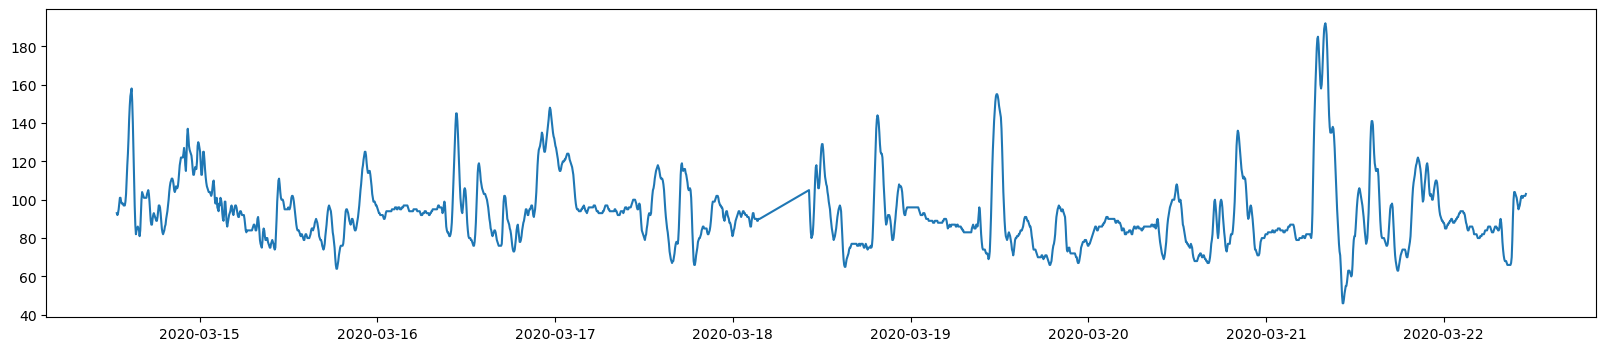

In [6]:
# Example of glucose curve
plt.figure(figsize=(20, 4))
plt.plot(cgm_data[7].glu)

## Fitting a linear model to time series data

In [13]:
# Transform CGM data for participant 1 to start at t=0 with data aggregated over 5 min intervals 
test_series = align_series(cgm_data, 1)
# Remove rows where any data is missing
test_series = test_series[~test_series.isnull().any(axis=1)]

In [15]:
test_series

,glucose,hr,eda,temp,acc,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl
datetime,,,,,,,,,,,,,
2020-02-13 17:25:00,61.0,71.495733,0.196041,33.570550,1.032958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:30:00,59.0,78.957767,0.489986,33.397567,1.491388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:35:00,58.0,78.527500,0.913637,32.964883,1.103554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:40:00,59.0,75.787167,1.243545,33.302100,1.162078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:45:00,63.0,75.992375,1.671315,33.274766,1.187590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-22 17:35:00,139.0,61.836433,0.122841,26.101350,0.105869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22 17:40:00,141.0,61.652900,0.123966,26.039450,0.093441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22 17:45:00,143.0,59.241000,0.116652,26.010400,0.167938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Cross validation loop for linear regression
def lr_cv_loop(data, model, features, target):
    n_splits = 5
    kfold = KFold(n_splits=n_splits)

    mses = np.zeros(n_splits)

    for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
        d_tr = data.iloc[train_idx]
        d_val = data.iloc[val_idx]
        model.fit(d_tr[features], d_tr[target])
        pred = model.predict(d_val[features])

        mses[i] = mean_squared_error(d_val[target], pred)

    return mses


Fit a `DummyRegressor` to get a baseline model and MSE.

In [16]:
# Start with a baseline model that's just the mean of glucose readings
features = ['hr', 'eda', 'temp', 'acc']
target = 'glucose'
exog = DummyRegressor(strategy='mean')
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.990156150439066

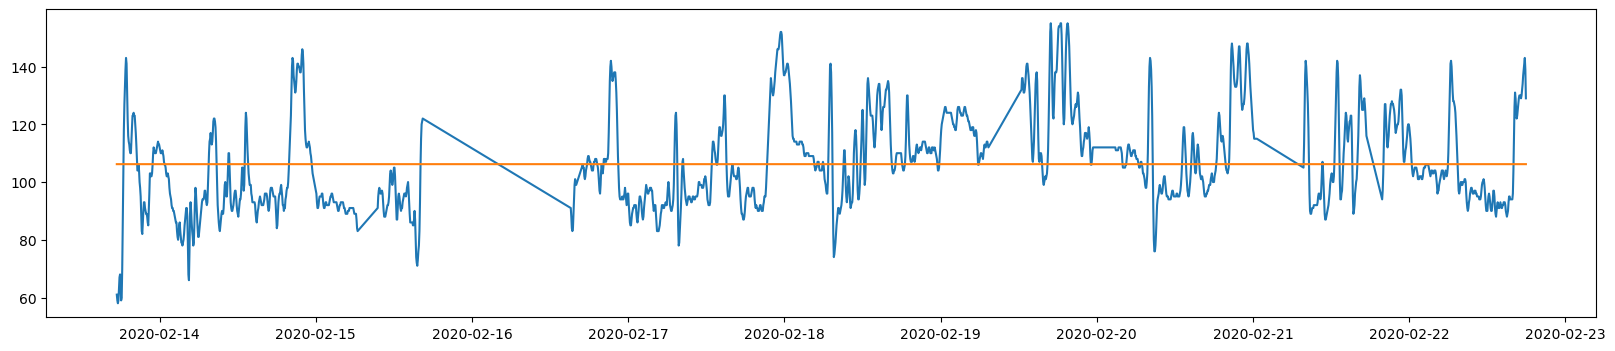

In [17]:
plt.figure(figsize=(20, 4))
plt.plot(test_series.index, test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

In [18]:
# Compare this with a simple linear model on the time series data
# Some of the peaks are captured by food consumption with the linear model, but lack any lasting effect
# Some of the trends and small variations are captured
# Score is a bit better than the baseline model
features = ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'protein', 'sugar', 'gi', 'gl']
target = 'glucose'
exog = LinearRegression()
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.820224751120023

MSE shows that the linear prediction model does better than the baseline. Unlike the actual glucose curve, food consumption in the prediction leads to a spike, but has no lasting effect. This is expected since the food information only appears a the time it was consumed in the data, and likely before the nutrients have been absorbed. Some of the baseline variation throughout the day is captured by the biometric data.

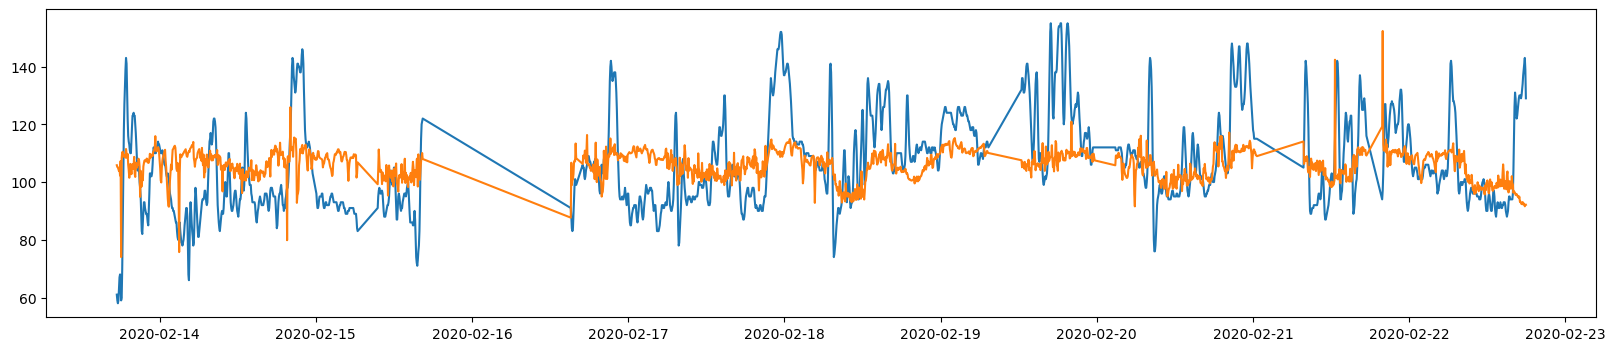

In [19]:
plt.figure(figsize=(20, 4))
plt.plot(test_series.index, test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

In [20]:
# Focusing just on variation from biometrics leads to better score than when including food
features = ['hr', 'eda', 'temp', 'acc']
target = 'glucose'
exog = LinearRegression()
mses = lr_cv_loop(test_series, exog, features, target)
np.sqrt(mses).mean()

16.75904143931296

Using just the biometric data with the linear model produces the best result so far.

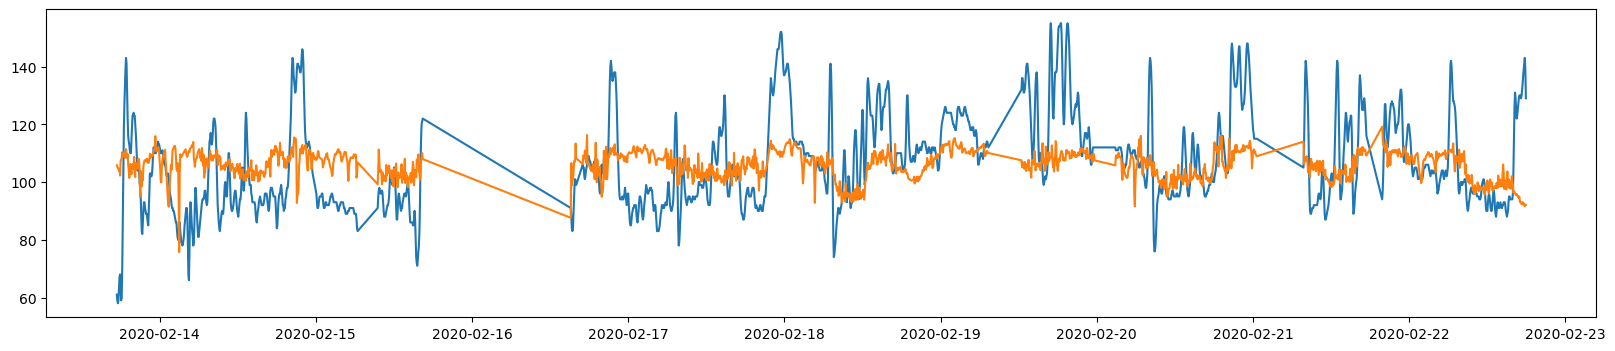

In [21]:
plt.figure(figsize=(20, 4))
plt.plot(test_series['glucose'])
plt.plot(test_series.index, exog.predict(test_series[features]))

## Fitting ADL model to time series data

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa as sm
from statsmodels.tsa.api import ARDL

In [23]:
tss = TimeSeriesSplit(n_splits=10)

for train_idx, val_idx in tss.split(test_series):
  g_tt = test_series['glucose'].iloc[train_idx]
  g_ho = test_series['glucose'].iloc[val_idx]


### ARIMA Fitting

In [24]:
# Fit and ARIMA model on just the glucose readings
auto_arima(test_series['glucose'], seasonal=True, trace=True, n_jobs=16)

c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9400.239, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10986.368, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9638.869, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10010.967, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10984.554, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9470.495, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9402.355, Time=1.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9384.836, Time=0.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9395.935, Time=0.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9362.395, Time=2.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9362.527, Time=2.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9368.601, Time=1.08 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AI

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True)

In [26]:
# Fit the model with the best parameters
series_start = pd.to_datetime("2020-02-13 17:25:00")
series_end = series_start + pd.Timedelta(days=8)
arima = ARIMA(test_series.loc[series_start:series_end, 'glucose'].values, order=(4, 1, 2)).fit()

c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Noah\miniconda3\envs\erdos_may_2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
test_series

,glucose,hr,eda,temp,acc,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,gi,gl
datetime,,,,,,,,,,,,,
2020-02-13 17:25:00,61.0,71.495733,0.196041,33.570550,1.032958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:30:00,59.0,78.957767,0.489986,33.397567,1.491388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:35:00,58.0,78.527500,0.913637,32.964883,1.103554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:40:00,59.0,75.787167,1.243545,33.302100,1.162078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-13 17:45:00,63.0,75.992375,1.671315,33.274766,1.187590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-22 17:35:00,139.0,61.836433,0.122841,26.101350,0.105869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22 17:40:00,141.0,61.652900,0.123966,26.039450,0.093441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22 17:45:00,143.0,59.241000,0.116652,26.010400,0.167938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With just ARIMA, the previous glucose readings are used, which quickly turns into a constant prediction. No long-term prediction potential.

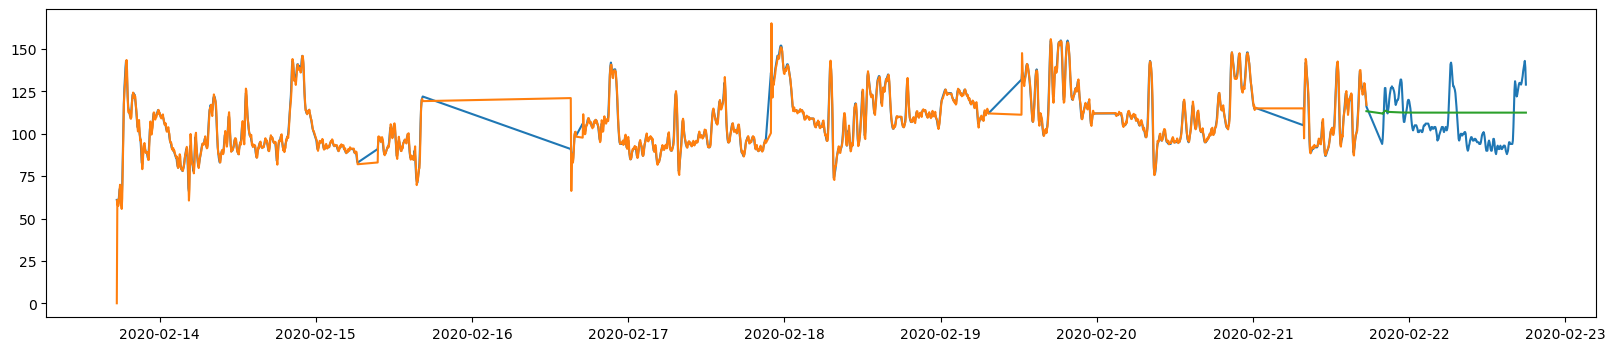

In [60]:
# See how the prediction looks with just ARIMA
plt.figure(figsize=(20, 4))
plt.plot(test_series['glucose'])
plt.plot(test_series.loc[series_start:series_end, 'glucose'].index, arima.fittedvalues)
plt.plot(test_series[series_end:].index, arima.predict(start=len(test_series.loc[series_start:series_end]), end=len(test_series)))

### ADL Full Model
The ADL (or ARDL in statsmodels) model uses the biometric and meal data to make predictions. In this case, the last 6 time steps or 30 minutes are used to make predictions.

In [61]:
# Checking how well a model fits with 6 lags on glucose and exogenous variables
exog = ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'protein', 'sugar', 'gi', 'gl']
# exog = ['calorie', 'total_carb', 'dietary_fiber', 'protein']
test_copy = test_series.copy()
test_copy.index = range(len(test_copy))
ardl = ARDL(test_copy.loc[:1500, 'glucose'], 1, test_copy.loc[:1500, exog], 6).fit()

For biometric data, the model summary shows that the last 5 minutes of acc and last 10 minutes of temperature and heart rate are significant. For the nutrition data, the data the previous 10-20 min is significant. This is expected given the delay in digesting and absorbing nutrients from a meal.

In [62]:
ardl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        ARDL Model Results                                       
=================================================================================================
Dep. Variable:                                   glucose   No. Observations:                 1501
Model:             ARDL(1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6)   Log Likelihood               -3805.223
Method:                                  Conditional MLE   S.D. of innovations              3.058
Date:                                   Thu, 18 Jul 2024   AIC                           7756.446
Time:                                           23:06:03   BIC                           8144.311
Sample:                                                6   HQIC                          7900.940
                                                    1501                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1169      2.160      1.906      0.057      -0.120       8.354
glucose.L1        0.9740      0.005    178.661      0.000       0.963       0.985
hr.L0             0.0345      0.012      2.969      0.003       0.012       0.057
hr.L1            -0.0266      0.012     -2.149      0.032      -0.051      -0.002
hr.L2            -0.0197      0.012     -1.591      0.112      -0.044       0.005
hr.L3            -0.0009      0.012     -0.076      0.939      -0.025       0.023
hr.L4             0.0003      0.012      0.022      0.982      -0.024       0.025
hr.L5             0.0004      0.012      0.034      0.973      -0.024       0.024
hr.L6             0.0113      0.011      0.995      0.320      -0.011       0.034
eda.L0            0.1142      0.073      1.555      0.120      -0.030       0.258
eda.L1           -0.0630      0.100     -0.631      0.528      -0.259       0.133
eda.L2           -0.0236      0.101     -0.234      0.815      -0.221       0.174
eda.L3            0.0167      0.101      0.166      0.868      -0.181       0.215
eda.L4           -0.0224      0.101     -0.223      0.824      -0.220       0.175
eda.L5           -0.0406      0.099     -0.409      0.683      -0.235       0.154
eda.L6           -0.0168      0.073     -0.232      0.816      -0.159       0.125
temp.L0           0.7136      0.155      4.605      0.000       0.410       1.018
temp.L1          -0.5669      0.217     -2.607      0.009      -0.993      -0.140
temp.L2          -0.1088      0.221     -0.493      0.622      -0.542       0.324
temp.L3          -0.1071      0.221     -0.484      0.628      -0.541       0.327
temp.L4          -0.0261      0.220     -0.119      0.906      -0.458       0.406
temp.L5          -0.1501      0.219     -0.685      0.494      -0.580       0.280
temp.L6           0.2060      0.158      1.301      0.194      -0.105       0.517
acc.L0           -1.2713      0.222     -5.728      0.000      -1.707      -0.836
acc.L1           -0.2784      0.244     -1.139      0.255      -0.758       0.201
acc.L2           -0.3861      0.246     -1.571      0.116      -0.868       0.096
acc.L3            0.0310      0.246      0.126      0.900      -0.452       0.514
acc.L4            0.2930      0.246      1.193      0.233      -0.189       0.775
acc.L5            0.7787      0.246      3.167      0.002       0.296       1.261
acc.L6            0.5944      0.230      2.581      0.010       0.143       1.046
calorie.L0        0.0122      0.007      1.706      0.088      -0.002       0.026
calorie.L1        0.0039      0.007      0.543      0.587      -0.010       0.018
calorie.L2        0.0026      0.007      0.360      0.719      -0.011       0.017
calorie.L3       -0.0105      0.007     -1.478      0.140      -0.024       0.003
calorie.L4       -0.0095      0.007 

The out of sample prediction seems to follow the trend and matches the peaks somewhat well. Going back to the beginning and predicting glucose from the exogenous variables seems to miss some peaks and adds in others, indicating the need for better food logging in terms of both time and the nutrition content.

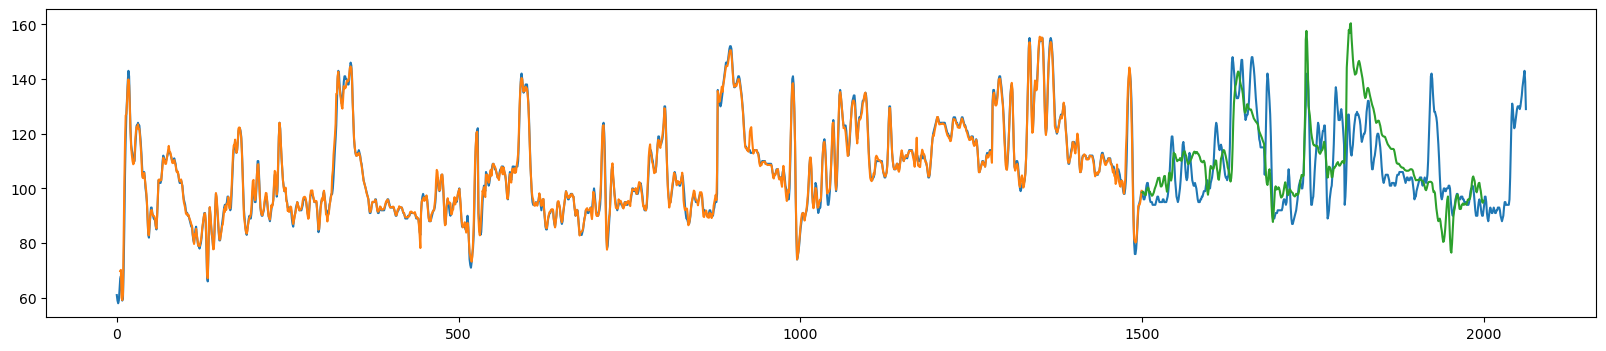

In [63]:
# Checking what the prediction looks like, orange is the fitted data, green is the prediction
# Not an exact match, but follows the trend
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[5:1500], ardl.fittedvalues)
plt.plot(test_copy.index[1500:2000], ardl.forecast(500, test_copy.loc[1500:, exog]))

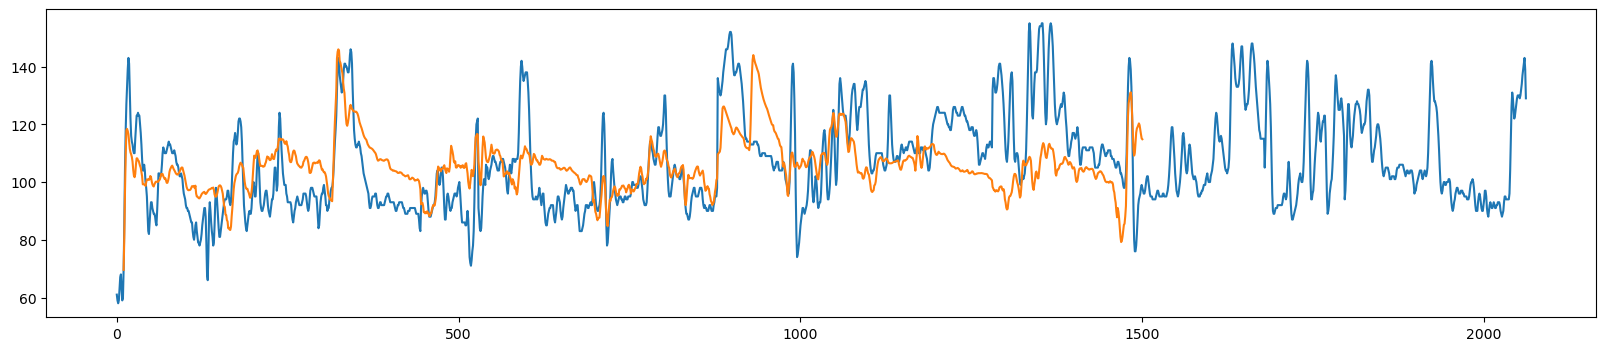

In [64]:
test_pred = ardl.get_prediction(dynamic=True, exog_oos=test_copy.loc[1500:, exog])
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[10:1501], test_pred.predicted_mean[10:])

Zooming in to investigate a specific peak. The ADL model seems to match the initial peak, but misses the sustained glucose level and takes longer to return to baseline. Though the baseline for the model is higher than the actual baseline, both return from the peak to the baseline at about the same time, around index 370.

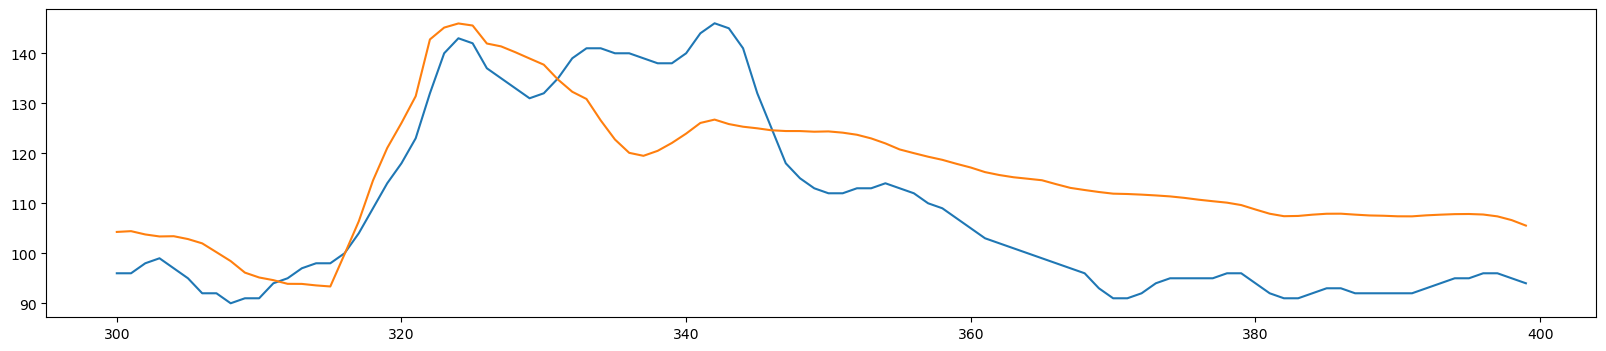

In [33]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index[300:400], test_copy['glucose'][300:400])
plt.plot(test_copy.index[300:400], test_pred.predicted_mean[300:400])

### ADL Food Only
Without the biometric data, ADL produces smooth exponential decay curves after every meal. Carb lags 3 and 4, and fiber lag 4 are significant. The model misses the baseline trend that is captured with the biometric data.

In [65]:
exog = ['calorie', 'total_carb', 'dietary_fiber', 'protein']
test_copy = test_series.copy()
test_copy.index = range(len(test_copy))
ardl = ARDL(test_copy.loc[:1500, 'glucose'], 1, test_copy.loc[:1500, exog], 6).fit()

In [66]:
ardl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:                 glucose   No. Observations:                 1501
Model:             ARDL(1, 6, 6, 6, 6)   Log Likelihood               -3917.343
Method:                Conditional MLE   S.D. of innovations              3.296
Date:                 Thu, 18 Jul 2024   AIC                           7896.686
Time:                         23:26:27   BIC                           8061.395
Sample:                              6   HQIC                          7958.046
                                  1501                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.4070      0.575      4.186      0.000       1.279       3.535
glucose.L1           0.9753      0.005    182.074      0.000       0.965       0.986
calorie.L0           0.0087      0.007      1.220      0.223      -0.005       0.023
calorie.L1           0.0038      0.007      0.526      0.599      -0.010       0.018
calorie.L2           0.0053      0.007      0.744      0.457      -0.009       0.019
calorie.L3          -0.0088      0.007     -1.234      0.218      -0.023       0.005
calorie.L4          -0.0042      0.007     -0.591      0.555      -0.018       0.010
calorie.L5           0.0028      0.007      0.388      0.698      -0.011       0.017
calorie.L6           0.0031      0.007      0.434      0.664      -0.011       0.017
total_carb.L0       -0.0345      0.038     -0.903      0.367      -0.109       0.040
total_carb.L1       -0.0012      0.038     -0.031      0.975      -0.076       0.074
total_carb.L2        0.0505      0.038      1.324      0.186      -0.024       0.125
total_carb.L3        0.1279      0.038      3.350      0.001       0.053       0.203
total_carb.L4        0.1293      0.038      3.387      0.001       0.054       0.204
total_carb.L5        0.0706      0.038      1.848      0.065      -0.004       0.146
total_carb.L6        0.0372      0.038      0.969      0.333      -0.038       0.112
dietary_fiber.L0    -2.6981      1.879     -1.436      0.151      -6.383       0.987
dietary_fiber.L1    -0.7292      1.879     -0.388      0.698      -4.414       2.956
dietary_fiber.L2     1.5760      1.879      0.839      0.402      -2.109       5.261
dietary_fiber.L3     3.3475      1.878      1.783      0.075      -0.336       7.031
dietary_fiber.L4     4.1234      1.877      2.197      0.028       0.442       7.805
dietary_fiber.L5     2.9106      1.876      1.552      0.121      -0.768       6.590
dietary_fiber.L6     1.7943      1.876      0.956      0.339      -1.886       5.474
protein.L0          -0.0758      0.075     -1.011      0.312      -0.223       0.071
protein.L1          -0.0145      0.075     -0.193      0.847      -0.161       0.132
protein.L2          -0.0337      0.075     -0.449      0.653      -0.181       0.113
protein.L3           0.0244      0.075      0.325      0.745      -0.123       0.171
protein.L4          -0.0386      0.075     -0.515      0.607      -0.185       0.108
protein.L5          -0.0648      0.075     -0.865      0.387      -0.212       0.082
protein.L6          -0.0473      0.075     -0.632      0.527      -0.194       0.100
====================================================================================
"""

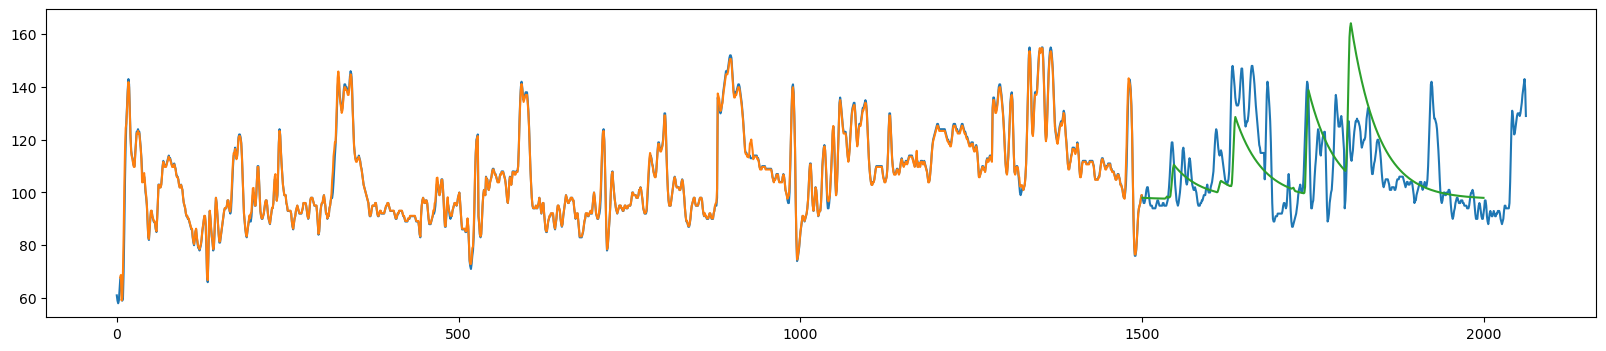

In [67]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[5:1500], ardl.fittedvalues)
plt.plot(test_copy.index[1500:2000], ardl.forecast(500, test_copy.loc[1500:, exog]))

In [68]:
test_pred = ardl.get_prediction(dynamic=True, exog_oos=test_copy.loc[1500:, exog])

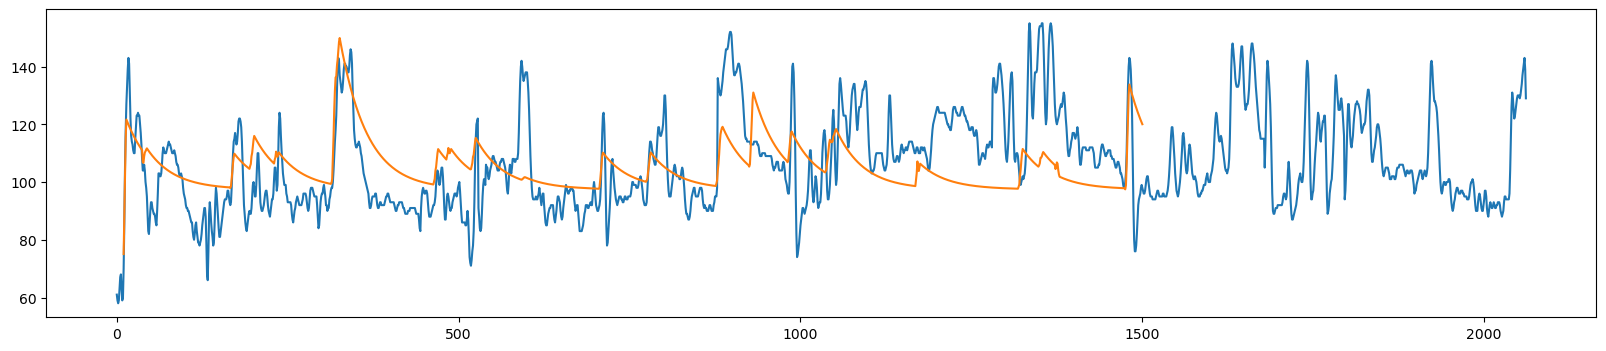

In [69]:
plt.figure(figsize=(20, 4))
plt.plot(test_copy.index, test_copy['glucose'])
plt.plot(test_copy.index[10:1501], test_pred.predicted_mean[10:])

## Run time series over all participants

In [69]:
# List of participant numbers with good data
included_participants = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16]
part_series = {}
for participant_num in included_participants:
    test_series = align_series(cgm_data, participant_num)
    # Remove portions with data not recorded from a device
    test_series = test_series[~test_series.isnull().any(axis=1)]
    part_series[participant_num] = test_series

In [73]:
# Run CV on one participant for one set of lag parameters
def time_series_cv(train, glu_lag, exog, lags, n_splits):
   target = ['glucose']
   ts_split = TimeSeriesSplit(n_splits)
   mses = np.zeros(n_splits)
   for i, (train_idx, val_idx) in enumerate(ts_split.split(train)):
      train_set = train.iloc[train_idx]
      val_set = train.iloc[val_idx]
      train_set.index = range(len(train_set))
      
      ardl_results = ARDL(train_set[target], glu_lag, train_set[exog], lags).fit()

      pred = ardl_results.forecast(len(val_idx), exog=val_set[exog])
      val_set.index = pred.index

      mses[i] = mean_squared_error(val_set[target], pred)
   return mses

# Run all lag combinations for a single participant
def optimize_participant(train, num_glu_lags, exog, num_exog_lags, n_splits):
   mses = np.zeros((num_glu_lags - 1, num_exog_lags - 1, n_splits))
   for i in range(1, num_glu_lags):
      for j in range(1, num_exog_lags):
         mses[i - 1, j - 1, :] = time_series_cv(train, i, exog, j, n_splits)

   return mses

In [74]:
# Set up parameter sets for each model
models = {
   'carb':['total_carb'],
   'gi': ['gi', 'gl'],
   'food': ['calorie', 'total_carb', 'sugar', 'protein'],
   'biometrics': ['hr', 'eda', 'temp', 'acc'],
   'gi_and_bio':['hr', 'eda', 'temp', 'acc', 'gi', 'gl'],
   'food_and_bio': ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'sugar', 'protein'],
   'all': ['hr', 'eda', 'temp', 'acc', 'calorie', 'total_carb', 'sugar', 'protein', 'gi', 'gl']
}
num_glu_lags = 6
num_exog_lags = 6
n_splits = 5
test_size = 0.2

# p7 and p13 don't have food aligned, p15 presented fitting issues
train_participants = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 16]

In [75]:
# Loop over every participant and model, storing the MSE in a 5D numpy array for processing

# Indexes are: participant, model, glu lag, exog lag, n_splits
mses = np.zeros((len(train_participants), len(models), num_glu_lags - 1, num_exog_lags - 1, n_splits))
for i, participant_num in enumerate(train_participants):
    print(participant_num)
    train, test = train_test_split(part_series[participant_num], shuffle=False, test_size=test_size)
    for model_num, exog in enumerate(models.values()):
        mses[i, model_num, :, :, :] = optimize_participant(
            train, num_glu_lags, exog, num_exog_lags, n_splits
        )

1
2
3
4
5
6
8
9
10
11
12
14
16


### ADL MSE Results

In [43]:
def get_mean_mses(all_mses):
    # Dimensions are participant, model, glu lag, exog lag
    return np.mean(all_mses, axis=4)

In [44]:
def get_models_with_lowest_mse(mean_mses):
    # Index of model with lowest mse for each participant
    return np.apply_over_axes(np.min, mean_mses, axes=(2, 3)).squeeze().argmin(axis=1) 

In [45]:
mean_mses = get_mean_mses(mses)

Results show that the best models across participants are 0 (carb), 1 (gi), 4 (gi and biometrics), 5 (food and biometrics). 

In [46]:
# Info on best model for each patient
get_models_with_lowest_mse(mean_mses)

array([5, 1, 0, 4, 4, 0, 4, 1, 1, 4, 1, 0, 0], dtype=int64)

In [47]:
def get_model_params(mean_mses, participant_idx, model_num):
    param_slice = mean_mses[participant_idx, model_num, :, :]
    return np.unravel_index(param_slice.argmin(), param_slice.shape)

In [48]:
get_model_params(mean_mses, 0, 0)

(0, 3)

The best lags for the best models seem to vary from 1-5 for glucose, while the exogenous variables favor 4-5 in most cases. The numbers in the pairs are one less than the actual number of lags in the model.

In [49]:
[get_model_params(mean_mses, i, j) for i,j in zip(range(len(train_participants)), get_models_with_lowest_mse(mean_mses))]

[(0, 2),
 (0, 0),
 (1, 4),
 (1, 0),
 (3, 4),
 (3, 4),
 (0, 3),
 (1, 4),
 (4, 4),
 (2, 3),
 (0, 4),
 (3, 4),
 (3, 4)]

Some participants, like in index 0, have good performance on any model, while at participant index 7, even the best model performs poorly compared to other participants.

In [50]:
# Participant index is on the left and the model index is on the top
pd.DataFrame(np.apply_over_axes(np.min, mean_mses, axes=(2, 3)).squeeze())

,0,1,2,3,4,5,6
0,244.202175,237.127799,230.511911,241.449720,213.487068,201.355736,204.017209
1,365.370554,364.398070,400.512981,370.132881,373.325294,426.641758,638.237336
2,375.975985,388.285230,629.266061,471.030199,456.009221,510.804573,501.276808
3,382.193038,382.512205,382.183019,351.591731,351.518199,366.376857,352.575832
4,155.237872,149.893364,224.817150,133.928094,112.803041,143.310036,144.047696
5,518.050641,554.896850,569.615407,732.988768,636.241640,679.459980,628.023354
6,278.994022,283.957156,286.269468,329.637565,273.721923,286.334869,284.560437
7,536.359115,523.092885,580.022629,668.122393,627.561933,638.406524,1018.498599
8,574.082100,538.058140,574.549648,646.117263,540.708230,779.298560,641.840917
9,475.502979,485.832262,489.639099,401.526047,399.270558,420.537962,440.350394


In [157]:
# Lowest mses for each participant
pd.DataFrame(np.round(np.apply_over_axes(np.min, mean_mses, axes=(1, 2, 3)).squeeze(), 2))

,0
0,201.36
1,364.40
2,375.98
3,351.52
4,112.80
5,518.05
6,273.72
7,523.09
8,538.06
9,399.27


### ADL Fit Charts

In [89]:
def validation_pred(series, glu_lag, exog, exog_lag):
    train, test = train_test_split(series, shuffle=False, test_size=0.2)
    train_idx = train.index
    test_idx = test.index
    train.index = range(len(train))
    test.index = range(len(test))
    ardl = ARDL(train['glucose'], glu_lag, train[exog], exog_lag).fit()
    
    pred = ardl.get_prediction(start=len(train), end=len(train)+len(test) - 1, exog_oos=test[exog])
    train.index = train_idx 
    test.index = test_idx 

    return train, test, pred


def plot_series_validation(train, test, ardl_pred):
    plt.figure(figsize=(10, 4))

    start_idx = len(train) - len(test)

    plt.plot(train.index[start_idx:], train.loc[train.index[start_idx: ], 'glucose'], color='tab:blue', label='train')
    plt.plot(test.index, test['glucose'], color='tab:green', label='test (actual)')
    plt.plot(test.index, ardl_pred.predicted_mean, color='tab:orange', alpha=0.7, label='test (prediction)')
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Blood Glucose Conc. (mg/dl)', fontsize=14)
    # plt.plot(test.index, ardl_pred.predicted_mean - 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')
    # plt.plot(test.index, ardl_pred.predicted_mean + 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')


Predictions for various models fit on participant 1. The flat regions indicate periods with data missing.

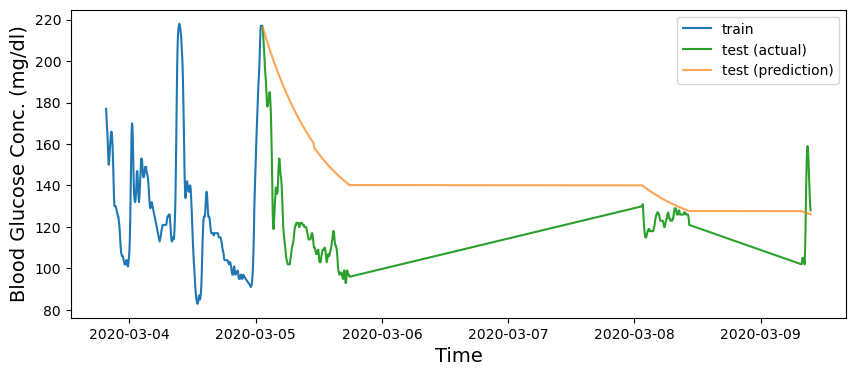

In [119]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['gi'], 3)
    plot_series_validation(a, b, c)

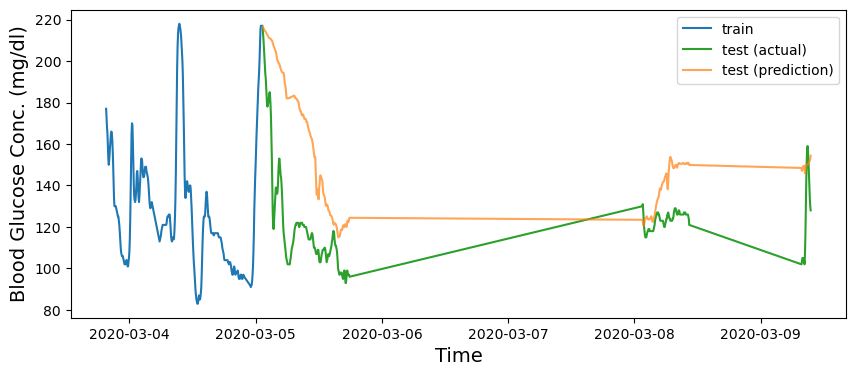

In [120]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['biometrics'], 3)
    plot_series_validation(a, b, c)

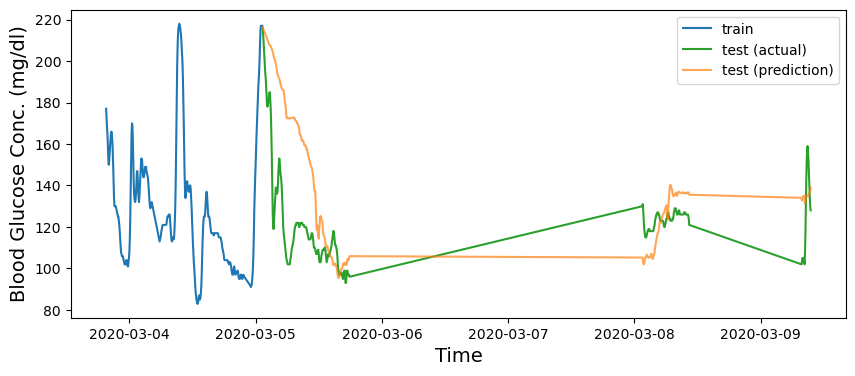

In [121]:
for i in train_participants[0:1]:
    a, b, c = validation_pred(part_series[i], 1, models['gi_and_bio'], 3)
    plot_series_validation(a, b, c)

In [154]:
def wow_pred(series, glu_lag, exog, exog_lag):
    train, test = train_test_split(series, shuffle=False, test_size=0.6)
    train_idx = train.index
    test_idx = test.index
    train.index = range(len(train))
    test.index = range(len(test))
    ardl = ARDL(train['glucose'], glu_lag, train[exog], exog_lag).fit()
    
    pred = ardl.get_prediction(start=len(train), end=len(train)+len(test) - 1, exog_oos=test[exog])
    train.index = train_idx 
    test.index = test_idx 

    return train, test, pred


def plot_series_wow(train, test, ardl_pred):
    plt.figure(figsize=(14, 4))

    start_idx = round(len(train) / 2)

    plt.plot(train.index[start_idx:], train.loc[train.index[start_idx: ], 'glucose'], color='tab:blue', label='train')
    plt.plot(test.index, test['glucose'], color='tab:green', label='test (actual)')
    plt.plot(test.index, ardl_pred.predicted_mean, color='tab:orange', alpha=0.7, label='test (prediction)')
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Blood Glucose Conc. (mg/dl)', fontsize=14)
    # plt.plot(test.index, ardl_pred.predicted_mean - 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')
    # plt.plot(test.index, ardl_pred.predicted_mean + 1.28 * ardl_pred.se_mean, color='tab:orange', linestyle='--')


Long term prediction from participant 5 fits most of the trends and peaks.

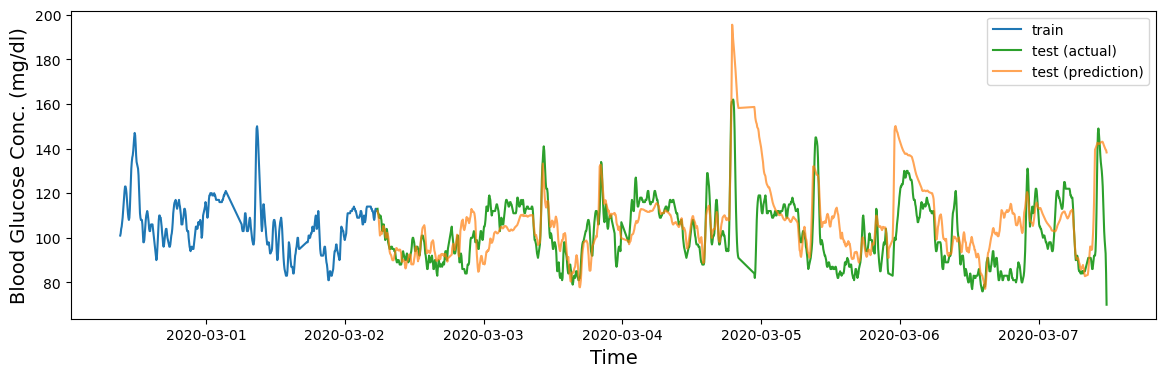

In [159]:
for i in train_participants[4:5]:
    a, b, c = wow_pred(part_series[i], 1, models['gi_and_bio'], 6)
    plot_series_wow(a, b, c)